# 0. Load libraries/dataset

In [1]:
# Load libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import contingency_matrix

from os.path import isfile

sns.set(style='ticks', color_codes=True)

# Load dataset
data_path = './datasets/assignment08_dataset.csv'

species = pd.DataFrame()
if not isfile(data_path):
    print("Dataset not found. Please check that the dataset exists and the path is correct.")
    
else:
    species = pd.read_csv(data_path)
    
# Make sure we have a copy of the orginal dataset
species_org = species.copy()

display(species)

,f1,f2
0,0.494261,1.451067
1,-1.428081,-0.837064
2,0.338559,1.038759
3,0.119001,-1.053976
4,1.122425,1.774937
...,...,...
745,0.505927,1.213927
746,-1.640461,-0.469973
747,-0.057139,-0.909261
748,-1.169394,0.039597


# 1. How many species are in this dataset?

Using a scatterplot we see that there are three 'blobs,' so it is likely that there are three species in the dataset.

Text(0, 1.0, '$f_2$')

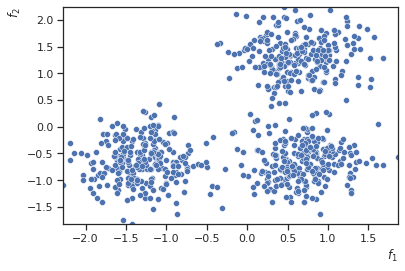

In [2]:
f1_max = species['f1'].max()
f1_min = species['f1'].min()

f2_max = species['f2'].max()
f2_min = species['f2'].min()

sns.scatterplot(x=species['f1'], y=species['f2'])
    
plt.xlim(f1_min, f1_max)
plt.ylim(f2_min, f2_max)
plt.xlabel(r'$f_1$', horizontalalignment='right', x=1.0)
plt.ylabel(r'$f_2$', horizontalalignment='right', y=1.0)

# 2. Find the rough feature ranges to classify these species correctly.

Based on the plots below let:
* species_a be the f1, f2 range \[-2.0:-0.7, -1.5:0.0\]
* species_b be the f1, f2 range \[0.0:1.3, -1.3:0.0\]
* species_c be the f1, f2 range \[0.0:1.3, 0.5:2.0\]

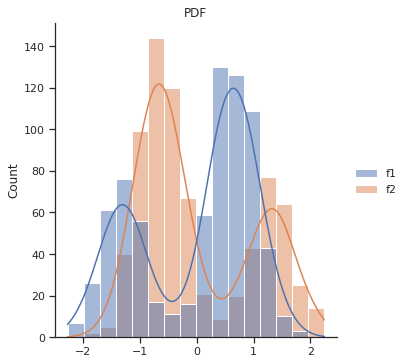

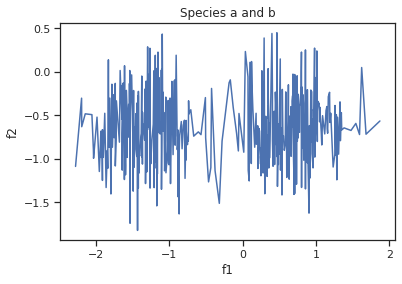

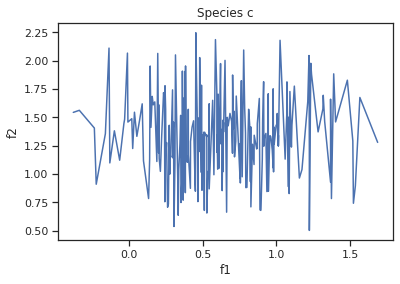

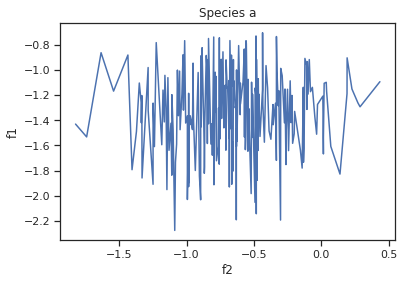

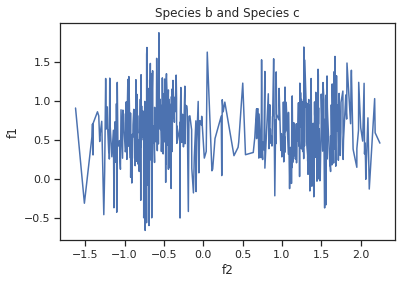

<Figure size 432x288 with 0 Axes>

In [3]:
# Let's see the beginning probability distribution
sns.displot(species, kde=True)
plt.title("PDF")
plt.show()
plt.clf()

# Let's subdivide and lineplot so we can eyeball 'em  a little closer
# f1's
specia_a_b = species[species['f2'] < 0.5]
sns.lineplot(x=specia_a_b['f1'], y=specia_a_b['f2'])
plt.title("Species a and b")
plt.show()
plt.clf()

specia_c = species[species['f2'] > 0.5]
sns.lineplot(x=specia_c['f1'], y=specia_c['f2'])
plt.title("Species c")
plt.show()
plt.clf()

# f2's
specia_a = species[species['f1'] < -0.7]
sns.lineplot(x=specia_a['f2'], y=specia_a['f1'])
plt.title("Species a")
plt.show()
plt.clf()

specia_b_c = species[species['f1'] > -0.7]
sns.lineplot(x=specia_b_c['f2'], y=specia_b_c['f1'])
plt.title("Species b and Species c")
plt.show()
plt.clf()


# 3. Clean the data of outliers.

Species a has 216) samples.
Species b has 212) samples.
Species c has 215) samples.


<AxesSubplot:xlabel='f1', ylabel='f2'>

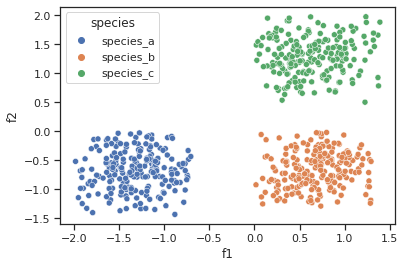

In [4]:
# Define the bounds as we defined in (2.)
species_a_bounds = {'f1': (-2.0,-0.7), 'f2':(-1.5,0.0)}
species_b_bounds = {'f1': (0.0,1.3), 'f2':(-1.3,0.0)}
species_c_bounds = {'f1': (0.0,1.4), 'f2':(0.5,2.0)}
          
# Function for isolating each species
def bound_species(bounds):
    temp_species = species.copy()
    
    for feat in bounds:
        lower = bounds[feat][0]
        upper = bounds[feat][1]
        
        temp_species = temp_species[temp_species[feat] > lower]
        temp_species = temp_species[temp_species[feat] < upper]
        
    return temp_species

# Isolate the species
species_a = bound_species(species_a_bounds)
species_b = bound_species(species_b_bounds)
species_c = bound_species(species_c_bounds)

# Add 'species' column to each (for hueing)
species_a['species'] = ['species_a']*species_a.shape[0]
species_b['species'] = ['species_b']*species_b.shape[0]
species_c['species'] = ['species_c']*species_c.shape[0]

# Display the number of samples from each, 
# so we know we haven't bounded one too aggressively.
disp_string = lambda df, name: print(f"{name} has {df.shape[0]}) samples.")
disp_string(species_a, "Species a")
disp_string(species_b, "Species b")
disp_string(species_c, "Species c")

# Concat into single bounded species table
bd_species = [species_a, species_b, species_c]
bd_species = pd.concat(bd_species)

# Show results
sns.scatterplot(x=bd_species['f1'], y=bd_species['f2'], hue=bd_species['species'])

# 4. Use K-means clustering to find anomalies.

In [5]:
# Declare, Fit, and Show Clusters
km = KMeans(n_clusters=3)
km.fit(bd_species.loc[:, bd_species.columns != 'species'])

km.cluster_centers_

array([[ 0.64272918,  1.28534697],
       [-1.31898   , -0.6798203 ],
       [ 0.68923042, -0.65850217]])

In [6]:
# Predict with our data to assign cluster identities
km_species = bd_species.copy()
km_species = km_species.drop(columns=['species'])

# Get the cluster assignments from KMeans
km_assign = km.predict(km_species)

# Add assignments as 'species'
km_species['species'] = km_assign

display(km_species)

,f1,f2,species
1,-1.428081,-0.837064,1
6,-1.301548,-0.762062,1
10,-1.215782,-0.601021,1
11,-1.250218,-1.057617,1
12,-1.051604,-0.780084,1
...,...,...,...
734,0.800860,0.881746,0
736,0.403732,1.165925,0
737,0.633083,0.852550,0
739,0.368551,0.768785,0


In [20]:
def detect_anomaly(cluster_df, model):
    
    anomalies = []
    
    # for each species
    for spec in cluster_df['species'].unique():
        anom_df = cluster_df.copy()
        
        # get cluster groups
        anom_df = anom_df[anom_df['species'] == spec]
        vals = anom_df.drop(columns=['species']).values
        
        # get get distances from the centroid
        centroid = km.cluster_centers_[spec]
        dists = [np.linalg.norm(val - centroid) for val in vals]
        
        # find points greater than a standard deviation from the centroid
        dist_std = np.std(dists)
        dist_mean = np.mean(dists)
        for idx, val in enumerate(vals):
            if dists[idx] > dist_mean + dist_std:
                anom = tuple(val)
                anomalies.append(anom)
             
    return anomalies
        
        
        
anoms = detect_anomaly(km_species, km)
for anom in anoms:
    

[(-1.85804701232, -1.33021784213),
 (-1.90824567176, -1.2485429432100001),
 (-0.8817961829700001, -1.4351452411899999),
 (-1.79245127675, -1.4045223247),
 (0.128494145161, -0.146277558271),
 (1.28828508776, -1.18972269812),
 (0.090657698723, -1.25434772582),
 (1.28361991963, -1.24163477985),
 (0.07381887630560001, -0.0563312160229),
 (0.077295305839, -1.13367252031),
 (1.36805202458, 1.65962813336),
 (1.22425496262, 0.501610912038),
 (1.23408760826, 1.9761904039900002),
 (1.2390151841200001, 1.8788219962200001),
 (1.38939876357, 1.8831629694099998),
 (1.37406167258, 0.78263972991),
 (0.14463869278799998, 1.95227594178),
 (0.306037432346, 0.536315500264)]